In [ ]:
# Clone model YOLOX from github
!git clone https://github.com/Megvii-BaseDetection/YOLOX.git

Cloning into 'YOLOX'...
remote: Enumerating objects: 1741, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (16/16), done.
remote: Total 1741 (delta 2), reused 7 (delta 1), pack-reused 1723
Receiving objects: 100% (1741/1741), 6.85 MiB | 23.54 MiB/s, done.
Resolving deltas: 100% (1022/1022), done.


To make it easier in applying GCAME, we make some changes in post-processing phase of the model. 
- Go to file ```./YOLOX/yolox/utils/boxes.py ``` and change function ```postprocess``` as follow:
```
def postprocess(prediction, num_classes, conf_thre=0.7, nms_thre=0.45, class_agnostic=False):
    box_corner = prediction.new(prediction.shape)
    box_corner[:, :, 0] = prediction[:, :, 0] - prediction[:, :, 2] / 2
    box_corner[:, :, 1] = prediction[:, :, 1] - prediction[:, :, 3] / 2
    box_corner[:, :, 2] = prediction[:, :, 0] + prediction[:, :, 2] / 2
    box_corner[:, :, 3] = prediction[:, :, 1] + prediction[:, :, 3] / 2
    prediction[:, :, :4] = box_corner[:, :, :4]
    idx = None
    output = [None for _ in range(len(prediction))]
    for i, image_pred in enumerate(prediction):

        # If none are remaining => process next image
        if not image_pred.size(0):
            continue
        # Get score and class with highest confidence
        class_conf, class_pred = torch.max(image_pred[:, 5: 5 + num_classes], 1, keepdim=True)

        conf_mask = (image_pred[:, 4] * class_conf.squeeze() >= conf_thre).squeeze()
        # Detections ordered as (x1, y1, x2, y2, obj_conf, class_conf, class_pred)
        detections = torch.cat((image_pred[:, :5], class_conf, class_pred.float()), 1)
        detections = detections[conf_mask]
        idx = (conf_mask == True).nonzero(as_tuple=True)[0]
        if not detections.size(0):
            continue

        if class_agnostic:
            nms_out_index = torchvision.ops.nms(
                detections[:, :4],
                detections[:, 4] * detections[:, 5],
                nms_thre,
            )
        else:
            nms_out_index = torchvision.ops.batched_nms(
                detections[:, :4],
                detections[:, 4] * detections[:, 5],
                detections[:, 6],
                nms_thre,
            )

        idx = idx[nms_out_index]
        detections = detections[nms_out_index]
        if output[i] is None:
            output[i] = detections
        else:
            output[i] = torch.cat((output[i], detections))

    return output, idx
```
(This function will return the output bounding box with the index of each box after running NMS algorithm)



In [ ]:
# Install all packages
!pip install -r ./YOLOX/requirements.txt
!pip install kornia

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 58 kB 3.2 MB/s 
     |████████████████████████████████| 145 kB 17.2 MB/s 
     |████████████████████████████████| 14.5 MB 39.7 MB/s 
     |████████████████████████████████| 4.5 MB 48.9 MB/s 
     |████████████████████████████████| 606 kB 38.0 MB/s 
  Created wheel for onnx-simplifier: filename=onnx_simplifier-0.3.5-py3-none-any.whl size=12879 sha256=56564be469b0bf26127fd2de67a22ab60ebf8f96bedfab9b98186c7f24504eb0
  Stored in directory: /root/.cache/pip/wheels/8a/b4/1b/6acdd4eb854b215cd4aa1c18ca79399f9d34728edaff47ecce
Successfully built onnx-simplifier
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 551 kB 6.2 MB/s 


In [ ]:
# Load the label of COCO dataset
coco = ['person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus', 'train', 'truck', 'boat',
                          'traffic light',
                          'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep',
                          'cow',
                          'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase',
                          'frisbee',
                          'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard',
                          'surfboard',
                          'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana',
                          'apple',
                          'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair',
                          'couch',
                          'potted plant', 'bed', 'dining table', 'toilet', 'tv', 'laptop', 'mouse', 'remote',
                          'keyboard', 'cell phone',
                          'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors',
                          'teddy bear',
                          'hair drier', 'toothbrush']

In [ ]:
import sys
sys.path.append('/content/YOLOX')

In [ ]:
# Import packages
from yolox import models
from yolox.utils import *
from yolox.data import data_augment

import torch
import torchvision
import numpy as np
from PIL import Image
from torchvision import transforms as T
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import cv2
from PIL import Image
from torch.nn import functional as F
import torch.nn as nn

import os
from tqdm import tqdm
import copy
import timeit

In [ ]:
# Get pretrained model and its transform function
# (In our paper, we use YOLOX-l to do experiment)
model = models.yolox_l(pretrained=True)
transform = data_augment.ValTransform(legacy=False)

Downloading: "https://github.com/Megvii-BaseDetection/YOLOX/releases/download/0.1.1rc0/yolox_l.pth" to /root/.cache/torch/hub/checkpoints/yolox_l.pth


  0%|          | 0.00/414M [00:00<?, ?B/s]

In [ ]:
# Name of all layers in YOLOX-l
for n, p in model.named_modules():
  print(n)


backbone
backbone.backbone
backbone.backbone.stem
backbone.backbone.stem.conv
backbone.backbone.stem.conv.conv
backbone.backbone.stem.conv.bn
backbone.backbone.stem.conv.act
backbone.backbone.dark2
backbone.backbone.dark2.0
backbone.backbone.dark2.0.conv
backbone.backbone.dark2.0.bn
backbone.backbone.dark2.0.act
backbone.backbone.dark2.1
backbone.backbone.dark2.1.conv1
backbone.backbone.dark2.1.conv1.conv
backbone.backbone.dark2.1.conv1.bn
backbone.backbone.dark2.1.conv1.act
backbone.backbone.dark2.1.conv2
backbone.backbone.dark2.1.conv2.conv
backbone.backbone.dark2.1.conv2.bn
backbone.backbone.dark2.1.conv2.act
backbone.backbone.dark2.1.conv3
backbone.backbone.dark2.1.conv3.conv
backbone.backbone.dark2.1.conv3.bn
backbone.backbone.dark2.1.conv3.act
backbone.backbone.dark2.1.m
backbone.backbone.dark2.1.m.0
backbone.backbone.dark2.1.m.0.conv1
backbone.backbone.dark2.1.m.0.conv1.conv
backbone.backbone.dark2.1.m.0.conv1.bn
backbone.backbone.dark2.1.m.0.conv1.act
backbone.backbone.dark2.1

In [ ]:
from math import floor
import math

# This function to create Gaussian mask used in algorithm
def create_heatmap(output_width, output_height, p_x, p_y, sigma):
    """
    Parameters: 
      - output_width, output_height: The kernel size of Gaussian mask
      - p_x, p_y: The center of Gaussian mask
      - sigma: The standard deviation of Gaussian mask
    Returns:
      - mask: The 2D-array Gaussian mask in range [0, 1]
    """
    X1 = np.linspace(1, output_width, output_width)
    Y1 = np.linspace(1, output_height, output_height)
    [X, Y] = np.meshgrid(X1, Y1)
    X = X - floor(p_x)
    Y = Y - floor(p_y)
    D2 = X * X + Y * Y
    E2 = 2.0 * sigma ** 2
    Exponent = D2 / E2
    mask = np.exp(-Exponent)
    mask = (mask - mask.min()) / (mask.max() - mask.min())
    return mask

class GCAME(object):
    def __init__(self, model, target_layers, img_size=(640, 640), **kwargs):
        """
        Parameters:
          - model: The model in nn.Module() to analyze
          - target_layers: List of names of the target layers in model.named_modules()
          - img_size: The size of image in tuple
        Variables:
          - self.gradients, self.activations: Dictionary to save the value when
            do forward/backward in format {'name_layer': activation_map/gradient}
          - self.handlers: List of hook functions
        """
        self.model = model.eval()
        self.img_size = img_size
        self.gradients = dict()           
        self.activations = dict()
        self.target_layers = target_layers
        self.handlers = []

        # Save gradient values and activation maps
        def save_grads(key):    
            def backward_hook(module, grad_inp, grad_out):
                g = grad_out[0].detach()
                self.gradients[key] = g
            return backward_hook

        def save_fmaps(key):
            def forward_hook(module, inp, output):
                self.activations[key] = output.detach() 
            return forward_hook
        
        for name, module in self.model.named_modules():        
            if name in self.target_layers:
                self.handlers.append(module.register_forward_hook(save_fmaps(name)))
                self.handlers.append(module.register_backward_hook(save_grads(name)))

    def remove_hook(self):
        """
        Remove all the forward/backward hook functions
        """
        for handle in self.handlers:
            handle.remove()

    def __call__(self, img, box, obj_idx=None):
        return self.forward(img, box, obj_idx)

    def forward(self, img, box, obj_idx=None):
      """
      Parameters:
        - img: Input image in Tensor[1, 3, H, W]
        - box: The bounding box to analyze Tensor([xmin, ymin, xmax, ymax, p_obj, p_cls, cls])
        - obj_index: The index of target bounding box in int
      Returns:
        - score_saliency_map: The saliency map of target object
      """
  
      eps = 1e-7
      b, c, h, w = img.shape
      self.model.zero_grad()
      # Get the prediction of the model and the index of each predicted bouding box
      pred = self.model(img)
      _, index = postprocess(pred, 80, 0.25, 0.45, True)

      # num_objs = box.shape[0]
      # target_box = box[:4]
      # target_score = box[4] * box[5]
      # pred_all_score = pred[0][index[obj_idx]][5:]

      target_cls = box[6].int()
      self.model.zero_grad()
      # Do backward
      pred[0][index[obj_idx]][target_cls + 5].backward(retain_graph=True)
      
      # Create the saliency map
      score_saliency_map = np.zeros((self.img_size[0], self.img_size[1]))

      for key in self.activations.keys():
        map = self.activations[key]
        grad = self.gradients[key]

        # Select the branch that the target comes out
        if grad.max().item() == 0 and grad.min().item() == 0:
          continue
        
        map = map.squeeze().cpu().numpy()
        grad = grad.squeeze().cpu().numpy()

        # Calculate the proportion between the input image and the gradient map
        stride = self.img_size[0] / grad.shape[1]
        for j in tqdm(range(map.shape[0])):
          weighted_map = map[j]
          mean_grad = np.mean(grad[j])

          # Get the center of the Gaussian mask
          id_x, id_y = (grad[j] != 0).nonzero()
          if len(id_x) == 0 or len(id_y) == 0:
            continue
          
          id_x = id_x[0]
          id_y = id_y[0]

          # Weight the feature map
          weighted_map = abs(mean_grad) * map[j]
          kn_size = math.floor(math.sqrt(grad.shape[1] * grad.shape[2]) - 1) / 2 / 3
          sigma = (np.log(abs(mean_grad)) / kn_size) * np.log(stride)
          mask = create_heatmap(grad[j].shape[1], grad[j].shape[0], id_y, id_x, abs(sigma))
          weighted_map *= mask
          weighted_map = cv2.resize(weighted_map, (self.img_size[1], self.img_size[0]))
          # weighted_map[weighted_map < 0.] = 0.
          if mean_grad > 0:
            score_saliency_map += weighted_map
          else:
            score_saliency_map -= weighted_map

      score_saliency_map[score_saliency_map < 0.] = 0
      score_saliency_map = (score_saliency_map - score_saliency_map.min()) / (score_saliency_map.max() - score_saliency_map.min() + eps)

      return score_saliency_map

In [ ]:
!wget https://raw.githubusercontent.com/Tianxiaomo/pytorch-YOLOv4/master/data/giraffe.jpg

--2022-11-15 02:56:20--  https://raw.githubusercontent.com/Tianxiaomo/pytorch-YOLOv4/master/data/giraffe.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 382965 (374K) [image/jpeg]
Saving to: ‘giraffe.jpg’

giraffe.jpg         100%[===================>] 373.99K  --.-KB/s    in 0.02s   

2022-11-15 02:56:20 (16.7 MB/s) - ‘giraffe.jpg’ saved [382965/382965]



In [ ]:
# Read and transform image
org_img = cv2.imread('./giraffe.jpg')
org_img = cv2.cvtColor(org_img, cv2.COLOR_BGR2RGB)
h, w, c = org_img.shape
ratio = min(640 / h, 640 / w)
img, _ = transform(org_img, None, (640, 640))
img = torch.from_numpy(img).unsqueeze(0)
img = img.float()

In [ ]:
img.requires_grad = False
device = 'cpu'
model.eval()
# Get prediction
with torch.no_grad():
  out = model(img.to(device))  
  box, index = postprocess(out, num_classes=80, conf_thre=0.25, nms_thre=0.45, class_agnostic=True)

In [ ]:
import matplotlib.colors as mcolors
overlap = {name for name in mcolors.CSS4_COLORS
           if f'xkcd:{name}' in mcolors.XKCD_COLORS}
all_colors = []
for color_name in overlap:
  css4 = mcolors.CSS4_COLORS[color_name]
  all_colors.append(css4)
  xkcd = mcolors.XKCD_COLORS[f'xkcd:{color_name}'].upper()
  all_colors.append(xkcd)

2


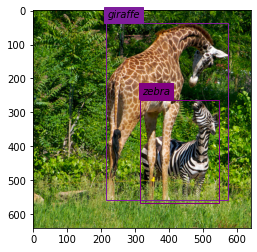

In [ ]:
# Show prediction
pred = box[0].cpu().detach().numpy()
fig, ax = plt.subplots()
for i, b in enumerate(pred):
  x1, y1, x2, y2 = b[:4]
  area = (x2 - x1) * (y2 - y1) 
  p_obj = b[4] * b[5]
  cls = int(b[6])
  ax.text(x1+5, y1-16, coco[cls], style='italic', bbox={
        'facecolor': all_colors[cls], 'boxstyle': 'square', 'edgecolor': all_colors[cls]})
  rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor=all_colors[cls], facecolor='none')
  ax.add_patch(rect)
ax.imshow(img.squeeze().numpy().transpose(1, 2, 0).astype(np.uint8))
print(len(pred))

In [30]:
box[0]

tensor([[212.7469,  37.0121, 574.3322, 557.4441,   0.9972,   0.9574,  23.0000],
        [314.7921, 262.0747, 546.0039, 566.5285,   0.9956,   0.9343,  22.0000]],
       grad_fn=<IndexBackward0>)

/usr/local/lib/python3.7/dist-packages/torch/nn/modules/module.py:1053: UserWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  warnings.warn("Using a non-full backward hook when the forward contains multiple autograd Nodes "
100%|██████████| 256/256 [00:00<00:00, 641.37it/s]


Time: 17.055432279999877s


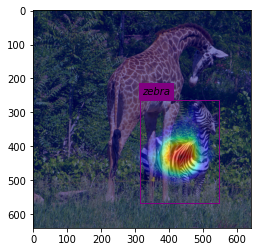

In [29]:
target_layer = [
    'head.cls_convs.0.0.act'
    'head.cls_convs.0.1.act',

    'head.cls_convs.1.0.act',
    'head.cls_convs.1.1.act',

    'head.cls_convs.2.0.act',
    'head.cls_convs.2.1.act',
  ]
model.zero_grad()
idx = 1
cam = GCAME(model, target_layer)
start = timeit.default_timer()
map = cam(img.to(device), box=box[0][idx], obj_idx=idx)
stop = timeit.default_timer()
print("Time: {}s".format(stop - start))

fig, ax = plt.subplots()
x1, y1, x2, y2 = box[0][idx][:4].detach().cpu().numpy()
cls = int(box[0][idx][6])
ax.text(x1+5, y1-16, coco[cls], style='italic', bbox={
          'facecolor': all_colors[cls], 'boxstyle': 'square', 'edgecolor': all_colors[cls]})
rect = patches.Rectangle((x1, y1), x2-x1, y2-y1, linewidth=1, edgecolor=all_colors[cls], facecolor='none')
ax.add_patch(rect)
ax.imshow(img.squeeze().numpy().transpose(1, 2, 0).astype(np.uint8))
ax.imshow(map, cmap='jet', alpha=0.5)